In [1]:
import sys
sys.path.append('../../../')


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from scipy import stats
import time

import torch as tc

from BayesNewton import bayesnewton
import objax

from sklearn.linear_model import LinearRegression

from rcgp.rcgp import TemporalRCGP


plt.rc('font', family='serif', size=20)
plt.rcParams['text.usetex'] = True

In [2]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
obs = data["last_price"].to_numpy()
obs_grid = np.arange(0, len(obs)) * 0.001 * 500

max_idx = 46800
center_idx = 2868

mean = obs[:max_idx].mean()
obs_std = obs[:max_idx].std()
obs = (obs[:max_idx] - mean)/obs_std
obs_grid = obs_grid[:max_idx]

print("Dataset Size : {}".format(len(obs)))

Dataset Size : 46800


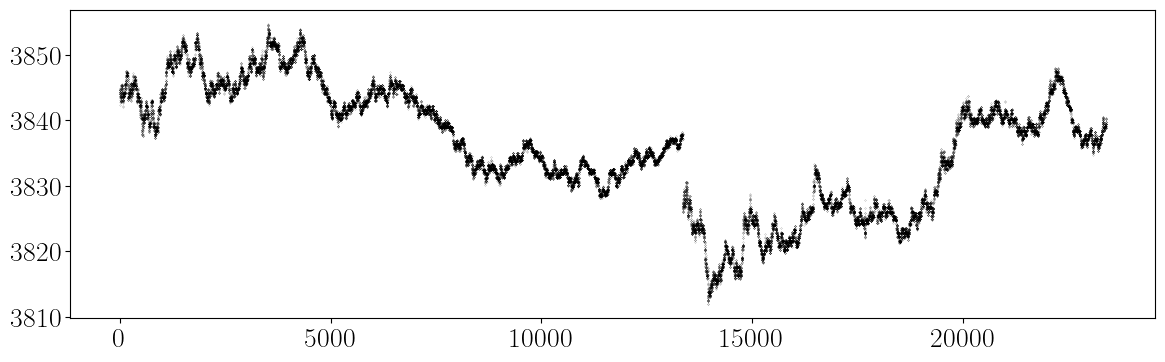

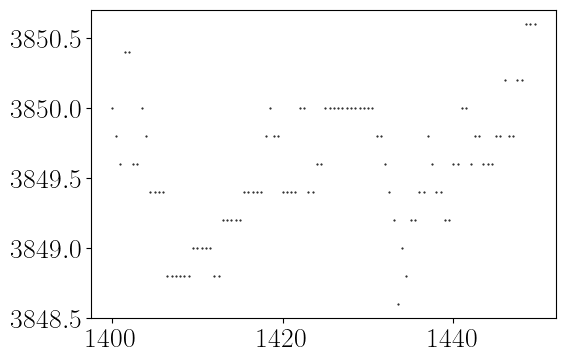

In [3]:
plt.figure(figsize=(14,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=5.)
plt.plot(obs_grid, obs * obs_std + mean, '.', color='black', markersize=0.2)

plt.figure(figsize=(6,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=10.)
plt.plot(obs_grid[2800:2900], obs[2800:2900] * obs_std + mean, '.', color='black', markersize=1)

In [4]:
def neg_log_likelihood(Y, pred, var):
    z = (Y - pred) / np.sqrt(var)
    print("Student-t", np.nanmean(stats.t.logpdf(z, df=1)))
    print("Normal", np.nanmean(stats.norm.logpdf(z)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    return np.abs(predictions - targets).mean()

def nlpd(y_true, mu_pred, sigma_pred):

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    mu_pred = np.array(mu_pred)
    sigma_pred = np.array(sigma_pred)
    
    # Avoid division by zero or invalid log by adding a small epsilon to sigma
    epsilon = 1e-8
    sigma_pred = np.maximum(sigma_pred, epsilon)
    
    # Compute log predictive density for Gaussian
    log_pdf = -0.5 * np.log(2 * np.pi * sigma_pred**2) - ((y_true - mu_pred)**2 / (2 * sigma_pred**2))
    
    # Compute and return the NLPD
    nlpd = -np.mean(log_pdf)
    return nlpd

In [5]:
def stgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.deactivate_robustness()

        rtgp.temporal_lengthscale = 6.
        rtgp.temporal_magnitude = 6.
        rtgp.var_y = 0.14**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [6]:
def rtgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.activate_robustness(func='m_pred')
        rtgp.adaptive_c()
        rtgp.temporal_lengthscale = 6.5
        rtgp.temporal_magnitude = 1.
        rtgp.var_y = 0.3**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [7]:
def bayes_newton_EP(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output:print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output: print("Negative Log Predictive Density: ")
    if return_output: print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


    if return_output: print("Prediction time (s) : ", t2 - t1)
    if return_output:print("Lengthscale : ", model.kernel.lengthscale)
    if return_output:print("Kernel Variance : ", model.kernel.variance)
    #print("Likelihood Variance : ", model.likelihood.variance)

    if return_output:
        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [8]:
def bayes_newton_variational(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:

        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [9]:
def bayes_newton_laplace(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 1.  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=4)
    model = bayesnewton.models.MarkovLaplaceGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 0.8
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: 
        print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:
        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model

    else:
        return t2 - t1

In [10]:
def get_onestep_speed(method):
    n_pts = [5, 10, 100, 500, 1000, 2000, 2500, 4000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, len(obs)]
    ts = []
    i = 0 #location in dataset
    for n in n_pts:
        ts.append(method(obs_grid[int(i * n):int((i+1) * n)], obs[int(i * n):int((i+1) * n)], return_output=False))
        
    return np.array(n_pts), np.array(ts)

In [11]:
#Uncomment if necessary only. Code to get execution time.
"""
comp_times = []

for i in range(5):
    print("First...")
    n_pts, rtgp_one_step_times = get_onestep_speed(rtgp);
    print("Second...")
    _, gp_one_step_times = get_onestep_speed(stgp);
    print("Third...")
    _, mep_one_step_times = get_onestep_speed(bayes_newton_EP);
    print("Fourth...")
    _, mvi_one_step_times = get_onestep_speed(bayes_newton_variational);
    print("Fifth...")
    _, mlgp_one_step_times = get_onestep_speed(bayes_newton_laplace);

    comp_times.append([n_pts.flatten(), rtgp_one_step_times, gp_one_step_times, mep_one_step_times, mvi_one_step_times, mlgp_one_step_times])

np.save('comp-times.npy', np.array(comp_times), allow_pickle=True)

"""


'\ncomp_times = []\n\nfor i in range(5):\n    print("First...")\n    n_pts, rtgp_one_step_times = get_onestep_speed(rtgp);\n    print("Second...")\n    _, gp_one_step_times = get_onestep_speed(stgp);\n    print("Third...")\n    _, mep_one_step_times = get_onestep_speed(bayes_newton_EP);\n    print("Fourth...")\n    _, mvi_one_step_times = get_onestep_speed(bayes_newton_variational);\n    print("Fifth...")\n    _, mlgp_one_step_times = get_onestep_speed(bayes_newton_laplace);\n\n    comp_times.append([n_pts.flatten(), rtgp_one_step_times, gp_one_step_times, mep_one_step_times, mvi_one_step_times, mlgp_one_step_times])\n\nnp.save(\'comp-times.npy\', np.array(comp_times), allow_pickle=True)\n\n'

In [12]:
comp_times=np.load('comp-times.npy', allow_pickle=True)

In [13]:
comp_times[:, 1, :].shape

(5, 18)

In [14]:
for i, name in enumerate(['ST-RCGP', 'STGP', 'MEP', 'MVI', 'MLa']):
    print(i+1,name)
    arr = comp_times[:4, i+1, :]
    print("Total (s) : ", arr.mean(axis=0)[-1], arr.std(axis=0)[-1])

    slope = []
    n_pts = comp_times[0, 0, :].reshape(-1,1)
    for j in range(4):
        data = arr[j, :].reshape(-1,1)
        lm = LinearRegression()
        lm.fit(n_pts, data)
        slope.append(lm.coef_[0] * 1000)
    
    print("1-Step (ms) : ", np.mean(slope), np.std(slope))

1 ST-RCGP
Total (s) :  9.360330879688263 0.422743328209273
1-Step (ms) :  0.199025249991804 0.017334830125992733
2 STGP
Total (s) :  7.976068556308746 0.7064320452566
1-Step (ms) :  0.16552110856106464 0.00767783924766593
3 MEP
Total (s) :  29.095697820186615 0.44841390174531814
1-Step (ms) :  0.5953251654275481 0.013068882199379638
4 MVI
Total (s) :  28.257311165332794 0.6179961714670966
1-Step (ms) :  0.6082252574501514 0.014213357169383368
5 MLa
Total (s) :  29.201807260513306 1.9628028724482267
1-Step (ms) :  0.6155404194107187 0.030287060462741235


In [15]:
lm.fit(n_pts, comp_times[:, 2, :].mean(axis=0).reshape(-1,1)).coef_

array([[0.00018229]])

In [16]:
slope

[array([0.59952656]),
 array([0.57589848]),
 array([0.65546198]),
 array([0.63127466])]

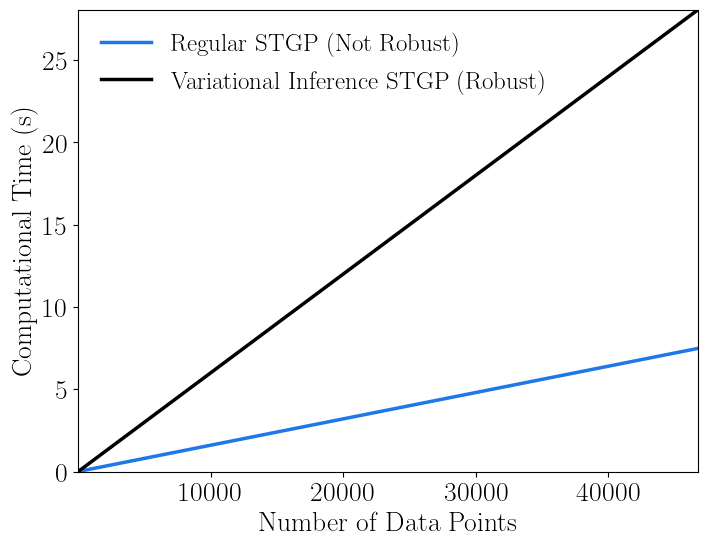

In [17]:
matplotlib.rcParams['lines.linewidth'] = 2.5

plt_arr = comp_times[1:].mean(axis=1).copy()
plt.figure(figsize=(8,6))
plt.plot(n_pts.flatten(), n_pts.flatten() * 0.16 / 1000, color="#1f77e9", label='Regular STGP (Not Robust)')
plt.plot(n_pts.flatten(), n_pts.flatten() * 0.6 / 1000, color="black", label='Variational Inference STGP (Robust)')

plt.xlim(n_pts[0], n_pts[-1])
plt.ylim(0, (n_pts.flatten() * 0.6 / 1000)[-1])

plt.ylabel("Computational Time (s)")
plt.xlabel("Number of Data Points")
plt.legend(fontsize=18, frameon=False)

#plt.savefig("comp_time_stgp_vs_VI-stgp.pdf", format='pdf', bbox_inches='tight')
#plt.legend(bbox_to_anchor=(1.3,-0.2), fontsize=16, labelspacing = 1, frameon=False, shadow=True, markerscale=2, ncol=1)

In [18]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
true_obs = data["last_price"].to_numpy()[:1000]
obs = true_obs.copy()
obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

center_idx = 500
outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
    drop += np.random.normal(0, 0.0001)
    obs[i] = obs[i]*drop

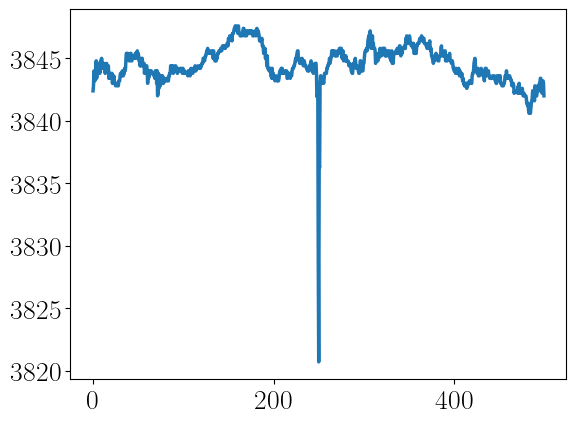

In [19]:
plt.plot(obs_grid, obs)

In [44]:
def compute_means(seed=0):
    np.random.seed(seed)

    data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
    true_obs = data["last_price"].to_numpy()[:1000]
    obs = true_obs.copy()
    obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

    center_idx = 500
    outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

    for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
        drop += np.random.normal(0, 0.0001)
        obs[i] = obs[i]*drop
    

    mean = obs.mean()
    obs_std = obs.std()
    obs = (obs- mean)/obs_std
    true_obs = (true_obs - mean)/obs_std

    m_rtgp, P_rtgp = rtgp(obs_grid, obs)
    m_std_gp, P_std_gp = stgp(obs_grid, obs)
    mu_EP, std_EP, EP_model = bayes_newton_EP(obs_grid, obs)
    mu_VI, std_VI, VI_model = bayes_newton_variational(obs_grid, obs)
    mu_laplace, std_laplace, laplace_model = bayes_newton_laplace(obs_grid, obs)

    return (mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs, obs, outliers_idx

In [ ]:
#Uncomment if necessary
"""rmses = []
nlpds = []

for i in range(20):
    (mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs, actual_obs, _ = compute_means(seed=i*10)
    rmses.append( [rmse(mu_VI, true_obs), rmse(m_rtgp.flatten(), true_obs), rmse(m_std_gp.flatten(), true_obs), rmse(mu_EP, true_obs), rmse(mu_laplace, true_obs)] )
    nlpds.append( [nlpd(true_obs, mu_VI, std_VI), nlpd(true_obs, m_rtgp.flatten(), P_rtgp.flatten()), nlpd(true_obs, m_std_gp.flatten(), P_std_gp.flatten()), nlpd(true_obs, mu_EP, std_EP), nlpd(true_obs, mu_laplace, std_laplace)] )

"""

'rmses = []\nnlpds = []\n\nfor i in range(20):\n    (mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs, actual_obs = compute_means(seed=i*10)\n    rmses.append( [rmse(mu_VI, true_obs), rmse(m_rtgp.flatten(), true_obs), rmse(m_std_gp.flatten(), true_obs), rmse(mu_EP, true_obs), rmse(mu_laplace, true_obs)] )\n    nlpds.append( [nlpd(true_obs, mu_VI, std_VI), nlpd(true_obs, m_rtgp.flatten(), P_rtgp.flatten()), nlpd(true_obs, m_std_gp.flatten(), P_std_gp.flatten()), nlpd(true_obs, mu_EP, std_EP), nlpd(true_obs, mu_laplace, std_laplace)] )\n'

In [23]:
#VI, RTGP, STGP, EP, Laplace
np.array(rmses).mean(axis=0), np.array(rmses).std(axis=0)

(array([0.15383026, 0.148419  , 0.53825744, 0.14741017, 0.41267515]),
 array([0.01019389, 0.0022533 , 0.00458081, 0.00838054, 0.74674797]))

In [40]:
#Corrected Laplace
a = np.array(rmses)[:, -1]
a[a < 0.7].mean(), a[a<0.7].std()

(0.16924644166243027, 0.010468593423810917)

In [25]:
np.array(nlpds).mean(axis=0), np.array(nlpds).std(axis=0)

(array([-0.53380964, -0.60761967, 13.90805752, -0.56638476, -0.07863057]),
 array([0.03957745, 0.00685728, 0.26020525, 0.03093066, 1.2390052 ]))

In [26]:
a = np.array(nlpds)[:, -1]
a[a < 0].mean(), a[a < 0].std()

(-0.3948433733642939, 0.10295119939575999)

In [45]:
(mu_laplace, std_laplace), (mu_VI, std_VI), (mu_EP, std_EP), (m_rtgp, P_rtgp), (m_std_gp, P_std_gp), obs_grid, true_obs, actual_obs, outliers_idx = compute_means(seed=10)

Prediction time :  0.3548448085784912
Prediction time :  0.18074393272399902
optimisation time: 4.08 secs
Negative Log Predictive Density: 
-0.5806038990488701
Prediction time (s) :  0.9970548152923584
Lengthscale :  4.826440407717856
Kernel Variance :  0.4033639739585158
optimisation time: 4.48 secs
Negative Log Predictive Density: 
-0.5855893177511404
Prediction time (s) :  1.1583199501037598
Lengthscale :  4.774667191547447
Kernel Variance :  0.4171005418315028
optimisation time: 3.79 secs
Negative Log Predictive Density: 
-0.8018552622839877
Prediction time (s) :  0.7513377666473389
Lengthscale :  3.5783721169164076
Kernel Variance :  0.45015249177737365


Method | RMSE | MAE | NLPD
MVI 0.15169829158629103 0.09876195262555726 -0.5505166183026695
RTGP 0.1474590787144267 0.10314042798922676 -0.6102819614950771
STGP 0.5422163420603245 0.09902958416534534 14.133111468101953
MEP 0.14432450007289205 0.09761243875372096 -0.5772891896603675
MLGP 0.17227096176360301 0.08767743666912252 -0.4218547200868588


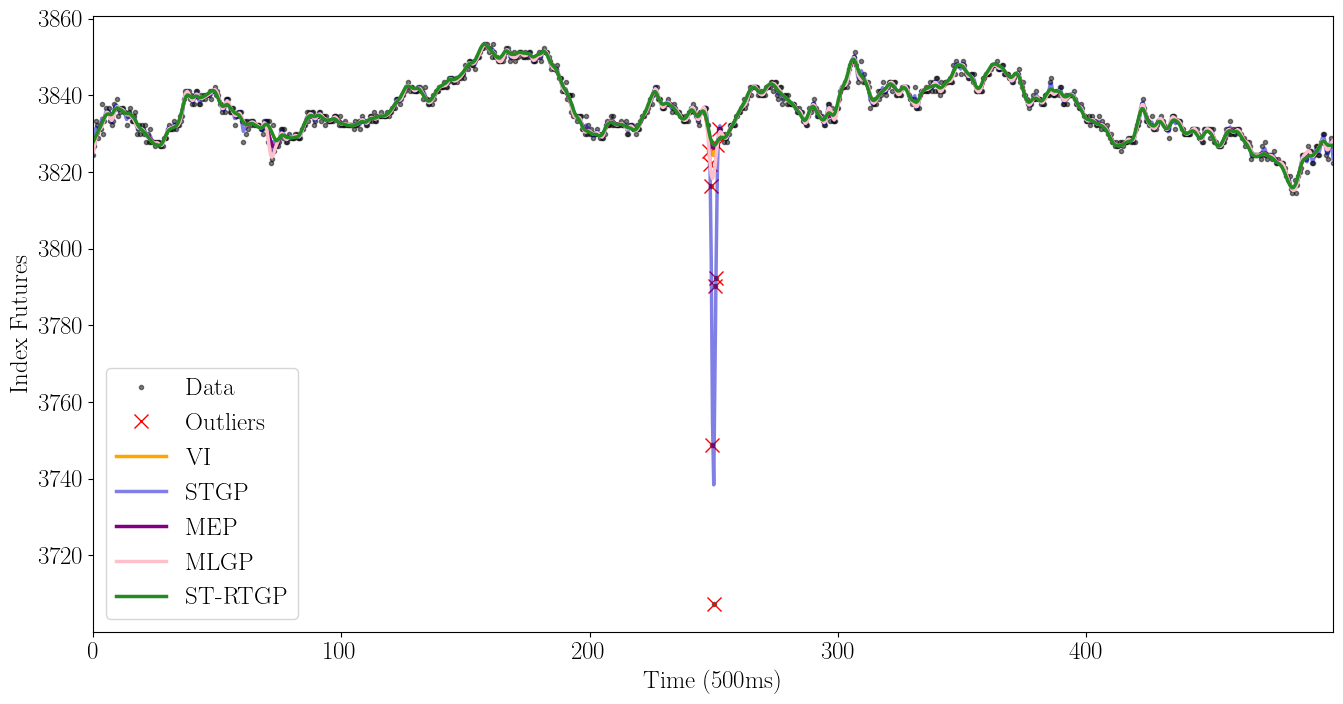

In [ ]:
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(16,8))
plt.plot(obs_grid, actual_obs*obs_std + mean, '.', alpha=0.5, color='black', label="Data")
plt.plot(obs_grid[outliers_idx], (actual_obs*obs_std + mean)[outliers_idx], 'x', markersize=10, color='red', label="Outliers")
plt.plot(obs_grid, obs_std*mu_VI + mean, color='orange', label='VI')
plt.plot(obs_grid, obs_std*m_std_gp.flatten() + mean, alpha=0.5, color='mediumblue', label="STGP")
plt.plot(obs_grid, obs_std*mu_EP + mean, color='purple', label="MEP")
plt.plot(obs_grid, obs_std*mu_laplace + mean, color='pink', label="MLGP")
plt.plot(obs_grid, obs_std*m_rtgp.flatten() + mean, color='forestgreen', label="ST-RTGP")
plt.xlim(obs_grid[0], obs_grid[-1])
plt.legend()

print("Method | RMSE | MAE | NLPD")
print("MVI", rmse(mu_VI, true_obs), mae(mu_VI, true_obs), nlpd(true_obs, mu_VI, std_VI))
print("RTGP", rmse(m_rtgp.flatten(), true_obs), mae(m_rtgp.flatten(), true_obs), nlpd(true_obs, m_rtgp.flatten(), P_rtgp.flatten()))
print("STGP", rmse(m_std_gp.flatten(), true_obs), mae(m_std_gp.flatten(), true_obs), nlpd(true_obs, m_std_gp.flatten(), P_std_gp.flatten()))
print("MEP", rmse(mu_EP, true_obs), mae(mu_EP, true_obs), nlpd(true_obs, mu_EP, std_EP))
print("MLGP", rmse(mu_laplace, true_obs), mae(mu_laplace, true_obs), nlpd(true_obs, mu_laplace, std_laplace))

plt.ylabel("Index Futures")
plt.xlabel("Time (500ms)")

#plt.savefig("./HFT-data-induced-crash-fit.pdf", format='pdf', bbox_inches='tight')